In [ ]:
!nvidia-smi

Sun May  1 12:20:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd '/content/drive/My Drive/'

import os

BASE_DIR = os.getcwd()

# BASE_DIR is working directory for this notebook
print(BASE_DIR)

Mounted at /content/drive
/content/drive/My Drive
/content/drive/My Drive


## Import libraries

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62
!pip install opencv-python-headless==4.5.2.52

!pip install -U albumentations

In [ ]:
import string
import json
import numpy as np
import matplotlib.pyplot as plt

from htr.preprocessing import get_augmentation_pipeline
from htr.generator import DataGenerator
from htr.network.models import *

from htr.evaluation import ocr_metrics

from tensorflow.keras.models import Model

# Load the TensorBoard notebook extension
%load_ext tensorboard

***Filepaths***

In [ ]:
# dataset_path = os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting1.hdf5')
dataset_path = os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting_128_64.hdf5')

***Parameters***

In [ ]:
# input_size = (256, 64, 1)
# max_text_len = 32
input_size = (128, 64, 1)
max_text_len = 16
batch_size = 32
epochs = 200

# charset = ''.join(json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting-characters.json'))))

charlist = json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'BanglaWriting-characters.json')))
charlist.remove(' ')
charset = ''.join(charlist)
print(len(charset))

90


***DataGenerator class***

In [ ]:
generator = DataGenerator(dataset_path=dataset_path,
                          input_size=input_size,
                          batch_size=batch_size,
                          max_text_len=max_text_len,
                          charset=charset,
                          aug= get_augmentation_pipeline(),
                          encoding='utf-8')

print('Images:', generator._size)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:691: FutureWarning: This class has been deprecated. Please use CoarseDropout
  FutureWarning,


Images: {'train': 18663, 'val': 829, 'test': 1244}


## *Flor*
### Model

In [ ]:
output_path = os.path.join(BASE_DIR, 'htr', 'data2', 'output-bangla-flor-ts16')
target_path = os.path.join(output_path, 'checkpoint_weights.hdf5')

In [ ]:
inputs, outputs = flor(input_size=input_size, d_model=generator.tokenizer.vocab_size + 1)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 128, 64, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 64, 32, 16)        160       
                                                                 
 p_re_lu (PReLU)             (None, 64, 32, 16)        16        
                                                                 
 batch_normalization (BatchN  (None, 64, 32, 16)       112       
 ormalization)                                                   
                                                                 
 full_gated_conv2d (FullGate  (None, 64, 32, 16)       4640      
 dConv2D)                                                        
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 32, 32)        4640  

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=ctc_loss)

# Load weights from target_path
if os.path.isfile(target_path):
    model.load_weights(target_path)
    print('===== Pre-trained weights loaded =====')

===== Pre-trained weights loaded =====


### Training

In [ ]:
callbacks = get_callbacks(logdir=output_path,
                          checkpoint_filepath=target_path,
                          verbose=1,
                          stop_patience=20,
                          reduce_patience=4)

In [ ]:
model.fit(x=generator.next_train_batch(),
          steps_per_epoch=generator._steps['train'],
          validation_data=generator.next_val_batch(),
          validation_steps=generator._steps['val'],
          epochs=epochs,
          callbacks=callbacks,
          verbose=1)

Epoch 1/200
584/584 [==============================] - ETA: 0s - loss: 2.1617
Epoch 1: val_loss improved from inf to 2.65535, saving model to /content/drive/My Drive/htr/data2/output-bangla-flor-ts16/checkpoint_weights.hdf5
584/584 [==============================] - 96s 139ms/step - loss: 2.1617 - val_loss: 2.6553 - lr: 0.0010
Epoch 2/200
584/584 [==============================] - ETA: 0s - loss: 2.3402
Epoch 2: val_loss improved from 2.65535 to 2.55926, saving model to /content/drive/My Drive/htr/data2/output-bangla-flor-ts16/checkpoint_weights.hdf5
584/584 [==============================] - 83s 141ms/step - loss: 2.3402 - val_loss: 2.5593 - lr: 0.0010
Epoch 3/200
584/584 [==============================] - ETA: 0s - loss: 2.3391
Epoch 3: val_loss did not improve from 2.55926
584/584 [==============================] - 84s 144ms/step - loss: 2.3391 - val_loss: 2.6540 - lr: 0.0010
Epoch 4/200
584/584 [==============================] - ETA: 0s - loss: 2.3369
Epoch 4: val_loss did not impr

*Training history from CSVLogger callback*

Min val_loss: 2.175421476364136
Min val_loss epoch: 102


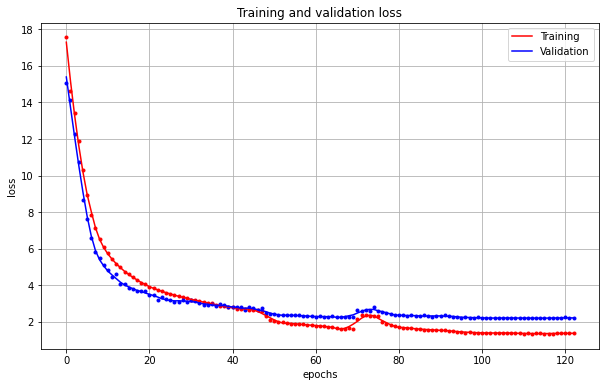

In [ ]:
from pandas import read_csv
from scipy.signal import savgol_filter
from ipywidgets import interact

path = os.path.join(output_path, 'epochs.log')
if os.path.isfile(path):
    history = read_csv(path)
    loss = history['loss']
    val_loss = history['val_loss']

    print('Min val_loss:', np.min(val_loss))
    print('Min val_loss epoch:', np.argmin(val_loss))

    # Plot training vs validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(loss, 'r.')
    plt.plot(val_loss, 'b.')
    # Smoothing
    plt.plot(savgol_filter(loss, 11, 3), 'r-', label='Training')
    plt.plot(savgol_filter(val_loss, 11, 3), 'b-', label='Validation')
    plt.title('Training and validation loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.grid('on')
    plt.show()

else:
    print("File doesn't exist")

*Logs from Tensorboard*

If tensorboard gets timed out or doesn't show up, it might be running on http://localhost:6006/.

In [ ]:
!find /content/drive/My\Drive/htr/data/output-bangla-flor | grep tfevents

/content/drive/MyDrive/htr/data/output-bangla-flor/train/events.out.tfevents.1626376179.182214c1d747.430.2555.v2
/content/drive/MyDrive/htr/data/output-bangla-flor/train/events.out.tfevents.1626441715.f29d4f748eb6.61.1645760.v2
/content/drive/MyDrive/htr/data/output-bangla-flor/validation/events.out.tfevents.1626376404.182214c1d747.430.16321.v2
/content/drive/MyDrive/htr/data/output-bangla-flor/validation/events.out.tfevents.1626441909.f29d4f748eb6.61.1659526.v2


In [ ]:
%tensorboard --logdir /content/drive/My\Drive/htr/data/output-bangla-flor

### Prediction | Evaluation

***Validation set***

In [ ]:
print('           VALIDATION SET           ')
Y_pred = model.predict(x=generator.next_val_batch(), steps=generator._steps['val'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['val']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           VALIDATION SET           
26/26 [==============================] - 1s 30ms/step
Y_pred shape: (829, 16, 93)
26/26 [==============================] - 16s 644ms/step

CTC decoded predictions len: 829
Character Error Rate (%) : 14.2715
Word Error Rate (%) : 36.7913
Sequence Error Rate (%) : 36.7913


***Test set***

In [ ]:
print('           TEST SET           ')
Y_pred = model.predict(x=generator.next_test_batch(), steps=generator._steps['test'], verbose=1)
print('Y_pred shape:', Y_pred.shape)

# Predictions, Probabilities after decoding
predictions, probabilities = ctc_decode(Y_pred=Y_pred, batch_size=batch_size, verbose=1)
print('\nCTC decoded predictions len:', len(predictions))

pred_texts = [generator.tokenizer.decode(y) for y in predictions]
gt_texts = [y.decode() for y in generator.dataset['test']['gt_texts']]

cer, wer, ser = ocr_metrics(pred_texts, gt_texts, lower=False) * 100
print(f'Character Error Rate (%) : {cer:.4f}')
print(f'Word Error Rate (%) : {wer:.4f}')
print(f'Sequence Error Rate (%) : {ser:.4f}')

           TEST SET           
39/39 [==============================] - 1s 29ms/step
Y_pred shape: (1244, 16, 93)
39/39 [==============================] - 15s 374ms/step

CTC decoded predictions len: 1244
Character Error Rate (%) : 13.9978
Word Error Rate (%) : 35.6511
Sequence Error Rate (%) : 35.6913
